## RF Modulation Recognition with Vitis-AI - Part-2

This is a modified scrpit, prepaired to run on the Google Colab with a reduced RF Dataset to 6% only.

Original project is located on the Xilinx GitHub repository:

https://github.com/Xilinx/Vitis-AI-Tutorials/tree/master/Design_Tutorials/10-RF_modulation_recognition


The reduced RF Dataset is located on my shared folder on the Google Drive.


###Run this script on the Host Computer in the Vitis-AI Docker.


At the end copy the compiled 'rfClassification.xmodel' to your FPGA board.

## Install Packages

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow import Tensor
print("Tensorflow version is ", tf.__version__)
print('Keras version      : ',keras.__version__)
import numpy as np
import os, sys
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import h5py as h5
from sklearn.metrics import classification_report, confusion_matrix
import random
import time
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from tensorflow.keras.layers import  Dropout, Activation, GlobalAveragePooling1D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras.layers import Reshape, Dense, Flatten, Add
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, History
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from random import shuffle
import glob
from sklearn.model_selection import train_test_split
from pathlib import Path
import pickle
from progressbar import ProgressBar
import matplotlib.pyplot as plt

2022-03-22 17:07:39.964255: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu:/usr/local/lib:/opt/vitis_ai/conda/envs/vitis-ai-tensorflow/lib
2022-03-22 17:07:39.964283: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Tensorflow version is  2.6.0
Keras version      :  2.6.0


## Download the reduced 2018.01 Dataset 
It has only 6.25% of original data. The file size is about 1.25 GB. Enough to test the model on DPU of the FPGA.

If you need a more accurate model, then use the original dataset. You need at least 20 GB of free disk space just for download.

Only 512 samples per SNR, only upper 12 SNRs are included in the reduced dataset.


In [2]:
# FILENAME = reduced_rf_dataset_XYZ.hdf5
# FILEID = 1O_pmhLc7t3W4ehsFFUfYOaZsvyEmNVkn

# wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=FILEID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=FILEID" -O FILENAME && rm -rf /tmp/cookies.txt

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1O_pmhLc7t3W4ehsFFUfYOaZsvyEmNVkn' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1O_pmhLc7t3W4ehsFFUfYOaZsvyEmNVkn" -O reduced_rf_dataset_XYZ.hdf5 && rm -rf /tmp/cookies.txt


In [3]:
!ls -l

total 1309168
-rw-rw-r-- 1 vitis-ai-user vitis-ai-group         36 Mar 22 16:58 arch_b1152.json
drwxrwxr-x 2 vitis-ai-user vitis-ai-group       4096 Mar 22 16:46 fp_model
-rw-r--r-- 1 vitis-ai-user vitis-ai-group 1340573696 Mar 22 16:44 reduced_rf_dataset_XYZ.hdf5


## 2018 Dataset 

### Read in RF Data
3 Arrays will be created. <br>
myData holds the 1024 I and Q time values for each input sample. <br>
myMods holds the one hot encoded RF class for each sample.<br>
mySNRs holds the SNR value for each sample.<br>



In [4]:
#Note this is needed to aviod a tensorFlow memory issue
os.environ['TF_FORCE_CPU_ALLOW_GROWTH'] = 'true'

In [5]:
# original dataset -     4096 frames per 26 SNR per 24 modulations
# reduced dataset  - only 512 framer per 13 SNR per 24 modulations

# one frame has 1024 x 2 I/Q samples

# data_file = '2018.01/GOLD_XYZ_OSC.0001_1024.hdf5'  # original dataset
data_file = 'reduced_rf_dataset_XYZ.hdf5'
file_handle = h5.File(data_file,'r+')

myData = file_handle['X'][:]  # 159744 IQ samples - 512 per 13 SNR x 24 modulations
myMods = file_handle['Y'][:]  # modulations = 24, one-hot encoding
mySNRs = file_handle['Z'][:]  # SNRs 26 x 4096 per snr

file_handle.close()

print(np.shape(myData))
print(np.shape(myMods))
print(np.shape(mySNRs))

np.random.seed(0)

(159744, 1024, 2)
(159744, 24)
(159744, 1)


### Remove AM-SSB-WC and AM-SSB_SC from the data set
If we leave the AM-SSB-WC and AM-SSB-SC modulations in the data set we will see lower accuracy after quantizing the model to INT8. This is becuase we can more accurately quantize the floating point input data if it is over a smaller range with fewer outlyers as in seen in the other modulations 

In the next step we will remove these two modulations from the data set. If you want to leave these modulations in, you can skip the next step. Leaving these in will cause an additonal 5% accuracy drop after quantizing.

In [6]:
#Skip this entire panel if you want to leave AM-SSB-WC and AM-SSB-SC modulations in the data set
#myData = np.concatenate((myData[0:1810432], myData[2023424:2555904]),axis=0)
#mySNRs = np.concatenate((mySNRs[0:1810432], mySNRs[2023424:2555904]),axis=0)
#myMods = np.concatenate((myMods[0:1810432], myMods[2023424:2555904]),axis=0)

myData = np.concatenate((myData[0:113152], myData[126464:159744]),axis=0)
mySNRs = np.concatenate((mySNRs[0:113152], mySNRs[126464:159744]),axis=0)
myMods = np.concatenate((myMods[0:113152], myMods[126464:159744]),axis=0)


#re-onehot encode myMods to 22 from 24
length = (np.size(myMods, axis=0))
temp = np.concatenate((myMods[:,0:17],myMods[:,19:24]), axis=1)
myMods = temp

mods = [
    'OOK',      '4ASK',      '8ASK',      'BPSK',   'QPSK',    '8PSK',
    '16PSK',    '32PSK',     '16APSK',    '32APSK', '64APSK',  '128APSK',
    '16QAM',    '32QAM',     '64QAM',     '128QAM', '256QAM',  
    'AM-DSB-WC', 'AM-DSB-SC', 'FM', 'GMSK','OQPSK']

num_classes = np.shape(mods)[0]
print("The number of classes is ", num_classes)


print(np.shape(myData))
print(np.shape(mySNRs))
print(np.shape(myMods))

print ("Max value of the data set = ", np.max(myData))
print ("Min value of the data set = ", np.min(myData))
print ("Mean value of the data set = ", np.mean(myData))
print ("Standard Deviation of the data set ", np.std(myData) )


The number of classes is  22
(146432, 1024, 2)
(146432, 1)
(146432, 22)
Max value of the data set =  4.5126915
Min value of the data set =  -4.457516
Mean value of the data set =  0.0006922224
Standard Deviation of the data set  0.7962071


### Reshape RF data to 2D Matrix
We will reshape both the I and Q data from a 1024 long vector to 2D 1024x1 matrix to be conpatabile with 2D convolution commands supported by the DPU

In [7]:
myDataRs = myData.reshape(myData.shape[0], 1024, 1, 2) 

### Slpit Data into Trainnig and Validation set
We will use 80% of the data for the Training set and 20% for the Test set. 
The random_state input to the the train_test_split function is set to 0, which means the 80/20 split will be done in a repeatable manner. 

In [8]:
X_train ,X_test ,Y_train ,Y_test, Z_train, Z_test =train_test_split(myDataRs, myMods, mySNRs, test_size=0.2, random_state=0)
print (np.shape(X_test))
print (np.shape(Y_test))
print (np.shape(Z_test))
print (np.shape(X_train))
print (np.shape(Y_train))
print (np.shape(Z_train))
del myData, myMods, mySNRs

(29287, 1024, 1, 2)
(29287, 22)
(29287, 1)
(117145, 1024, 1, 2)
(117145, 22)
(117145, 1)


## Vitis AI
The Vitis-AI tools will be used the Quantize and Compile the model for accleration on the DPU. <br>
Vitis-AI 1.3 now natively supports keras in TensorFlow2, and we can directly read in the .h5 model. 

## Quantize Model to INT8
The Vitis-AI Quantizer uses a  small set of unlabeled samples to analyze the distribution of the activations. We will use 1000 input samples from the test set. <br>

The quantized.h5 model that is produced will be used as input to the Vitis-AI Quantizer

In [9]:
# reload the model in case it was closed
!ls -l fp_model/
model = tf.keras.models.load_model('fp_model/rf-model-best.h5')
 
from tensorflow_model_optimization.quantization.keras import vitis_quantize
quantizer = vitis_quantize.VitisQuantizer(model)
quantized_model = quantizer.quantize_model(calib_dataset = X_test[1:1000])

# Save the model
!mkdir -p quantize_results
quantized_model.save('quantize_results/quantized_model.h5')
!ls -l quantize_results

total 1500
-rw-r--r-- 1 vitis-ai-user vitis-ai-group 1532920 Mar 22 16:33 rf-model-best.h5


2022-03-22 17:07:46.225299: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.7/site-packages/cv2/../../lib64:/opt/xilinx/xrt/lib:/usr/lib:/usr/lib/x86_64-linux-gnu:/usr/local/lib:/opt/vitis_ai/conda/envs/vitis-ai-tensorflow/lib
2022-03-22 17:07:46.225332: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-22 17:07:46.225370: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
/opt/vitis_ai/conda/envs/vitis-ai-tensorflow2/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  ca

[VAI INFO] Update custom_layer_type: []
[VAI INFO] Start CrossLayerEqualization...
10/10 [==============================] - 5s 584ms/step
[VAI INFO] CrossLayerEqualization Done.


2022-03-22 17:07:55.676364: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


[VAI INFO] Start Quantize Calibration...
32/32 [==============================] - 27s 390ms/step
[VAI INFO] Quantize Calibration Done.
[VAI INFO] Start Post-Quantize Adjustment...
[VAI INFO] Post-Quantize Adjustment Done.
[VAI INFO] Quantization Finished.
total 888
-rw-r--r-- 1 vitis-ai-user vitis-ai-group 907056 Mar 22 17:08 quantized_model.h5


### Load and Compile Model for Evaluation
We can now load and recompile the INT8 model and run evaluations to compare with the floating point model

### Evalute  Model INT8 Performance

In [10]:
# load quantized model
from tensorflow_model_optimization.quantization.keras import vitis_quantize
with vitis_quantize.quantize_scope():
  q_model = tf.keras.models.load_model('quantize_results/quantized_model.h5')

q_model.compile(loss='categorical_crossentropy', metrics=["accuracy"])

score = q_model.evaluate(X_test, Y_test,  verbose=0, batch_size=1024)
print(score)

[1.9708930253982544, 0.573940634727478]


The Overall Top-1 score has gone down by about 3% due to quantization

### Classification Report for INT8 Model

In [11]:
batch_size = 128
Y_pred = q_model.predict(X_test,batch_size=batch_size)
y_pred = np.argmax(Y_pred, axis = 1)
y_actual = np.argmax(Y_test, axis = 1)
classificationreport_int8 = classification_report(y_actual,y_pred, target_names=mods)
print(classificationreport_int8)

              precision    recall  f1-score   support

         OOK       0.97      1.00      0.98      1331
        4ASK       0.34      0.86      0.49      1340
        8ASK       0.88      1.00      0.93      1330
        BPSK       0.97      1.00      0.99      1328
        QPSK       0.99      0.92      0.96      1344
        8PSK       0.32      0.80      0.45      1297
       16PSK       0.00      0.00      0.00      1299
       32PSK       0.23      0.01      0.01      1293
      16APSK       0.82      0.91      0.87      1297
      32APSK       0.33      0.92      0.49      1289
      64APSK       0.02      0.00      0.00      1337
     128APSK       0.12      0.21      0.15      1321
       16QAM       0.28      0.09      0.14      1401
       32QAM       0.57      0.11      0.19      1312
       64QAM       0.38      0.14      0.21      1301
      128QAM       0.24      0.00      0.01      1365
      256QAM       0.17      0.20      0.19      1359
   AM-DSB-WC       0.72    

### Accuracy vs SNR for INT8 Model

In [12]:
batchsize = 128
progress = ProgressBar()
snrlist = np.unique(Z_test)
acc_snr_arr = []

# interate over SNRs
for snr in progress(snrlist):
    acc_arr = []
    i_SNR = np.where(Z_test==snr)
    X_SNR = X_test[i_SNR[0],:,:]
    Y_SNR = Y_test[i_SNR[0],:]
    X_SNR_len = np.shape(X_SNR)[0]
    total_batches = int(X_SNR_len/batchsize)
    
    for i in (range(0, total_batches)):
        x_batch, y_batch = X_SNR[i*batchsize:i*batchsize+batchsize], Y_SNR[i*batchsize:i*batchsize+batchsize]
        
        # model prediction
        pred = q_model.predict(x_batch)
        
        #Pediction values are 0-24, corresponding to indices representing different modulation types
        pred_ind = np.argmax(pred, axis=1)
        expected_ind = np.argmax(y_batch, axis=1)
        matches  = sum(np.equal(pred_ind, expected_ind))
        acc      = matches/batchsize
        acc_arr.append(acc)

    # Average the per-batch accuracy values
    accuracy = np.mean(acc_arr)
    acc_snr_arr.append(accuracy)
    print("SNR: ", snr, "accuracy", accuracy)

  7% (1 of 13) |#                        | Elapsed Time: 0:00:09 ETA:   0:01:51

SNR:  6 accuracy 0.43244485294117646


 15% (2 of 13) |###                      | Elapsed Time: 0:00:16 ETA:   0:01:20

SNR:  8 accuracy 0.5372242647058824


 23% (3 of 13) |#####                    | Elapsed Time: 0:00:23 ETA:   0:01:13

SNR:  10 accuracy 0.5721507352941176


 30% (4 of 13) |#######                  | Elapsed Time: 0:00:31 ETA:   0:01:06

SNR:  12 accuracy 0.5914522058823529


 38% (5 of 13) |#########                | Elapsed Time: 0:00:38 ETA:   0:00:58

SNR:  14 accuracy 0.5790441176470589


 46% (6 of 13) |###########              | Elapsed Time: 0:00:45 ETA:   0:00:51

SNR:  16 accuracy 0.5942095588235294


 53% (7 of 13) |#############            | Elapsed Time: 0:00:53 ETA:   0:00:43

SNR:  18 accuracy 0.5969669117647058


 61% (8 of 13) |###############          | Elapsed Time: 0:01:00 ETA:   0:00:36

SNR:  20 accuracy 0.59375


 69% (9 of 13) |#################        | Elapsed Time: 0:01:07 ETA:   0:00:29

SNR:  22 accuracy 0.59375


 76% (10 of 13) |##################      | Elapsed Time: 0:01:15 ETA:   0:00:22

SNR:  24 accuracy 0.5854779411764706


 84% (11 of 13) |####################    | Elapsed Time: 0:01:22 ETA:   0:00:14

SNR:  26 accuracy 0.5863970588235294


 92% (12 of 13) |######################  | Elapsed Time: 0:01:30 ETA:   0:00:07

SNR:  28 accuracy 0.5942095588235294


100% (13 of 13) |########################| Elapsed Time: 0:01:37 Time:  0:01:37


SNR:  30 accuracy 0.6024816176470589


<Figure size 72x72 with 0 Axes>

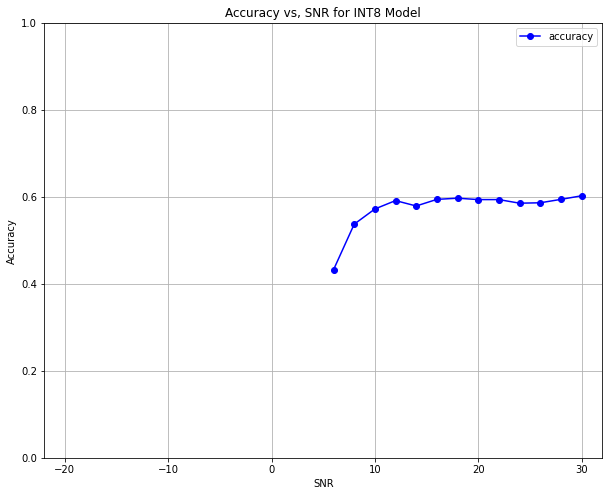

In [13]:
plt.figure(figsize=(1,1))
plt.show()
fig= plt.figure(figsize=(10,8))
plt.plot(snrlist, acc_snr_arr, 'bo-', label='accuracy')
plt.ylabel('Accuracy')
plt.xlabel('SNR')
plt.title("Accuracy vs, SNR for INT8 Model")
plt.legend()
plt.axis([-22, 32, 0, 1.0])
plt.grid()

The Accuracy vs SNR looks very similar to the floating point model, expect the accuracy is down by about 5% for higher SNRs from the floating point model

## Compile Model for DPU
The Vitis-AI compiler reads in the quantized model and generates an xmodel file which the instruction set for the Xilinx Deep Learning Processor (DPU). The arhictecture option (-a) is used to specify a json file which indicates which hw target the DPU is being compiled for.

In [14]:
#For AXU2CGB
!vai_c_tensorflow2 -m quantize_results/quantized_model.h5 -a arch_b1152.json -o vai_c_output -n rfClassification

**************************************************
* VITIS_AI Compilation - Xilinx Inc.
**************************************************
[INFO] Namespace(batchsize=1, inputs_shape=None, layout='NHWC', model_files=['quantize_results/quantized_model.h5'], model_type='tensorflow2', named_inputs_shape=None, out_filename='/tmp/rfClassification_org.xmodel', proto=None)
[INFO] tensorflow2 model: /workspace/quantize_results/quantized_model.h5
[INFO] keras version: 2.6.0
[INFO] Tensorflow Keras model type: functional
[INFO] generate xmodel     :100%|█| 112/112 [00:00<00:00, 2301.74it/s]          
[INFO] dump xmodel: /tmp/rfClassification_org.xmodel
[UNILOG][INFO] Compile mode: dpu
[UNILOG][INFO] Debug mode: function
[UNILOG][INFO] Target architecture: DPUCZDX8G_ISA0_B1152_0100002062010103
[UNILOG][INFO] Graph name: model_1, with op num: 206
[UNILOG][INFO] Begin to compile...
[UNILOG][INFO] Total device subgraph number 3, DPU subgraph number 1
[UNILOG][INFO] Compile done.
[UNILOG][INFO] The me

## Generate Graph Visualization with xir tool.
You will see a compiler message about the number of  subgraphs:
Total device subgraph number 3, DPU subgraph number 1 <br>
This means that are 3 subgraphs created, 1 for the input layer, 1 for for everything up the softmax layer (which runs on the DPU), and one for the softmax. <br>

The softmax layer can  optionally be acclerated in programmable logic, however in this tutorial we will implement the softmax layer on the CPU.

You can use the the xir command generate a .png file to visulize the graph layers.

In [15]:
!xir png /workspace/vai_c_output/rfClassification.xmodel xmodel.png

### Write out  samples  of Test Data to be used later for HW testing
The python function we will run in the target board will read in these numpy files containing the RF data, class, and SNR.

In [16]:
np.save('/workspace/rf_input.npy', X_test[0:1000,:,:])
np.save('/workspace/rf_classes.npy', Y_test[0:1000])
np.save('/workspace/rf_snrs.npy', Z_test[0:1000])

Now that a dpu xmodel file has been created you are ready to run on target board. You will need to copy the above 3 files, and the xmodel file from the compiler to your target board.

You can close this notebook by entering CtrlC at the console, close the docker container by entering CtrlD, and the proceed with the Tutorial readme instructions.